# Data Cleaning, Pre-processing, and Feature Engineering

This notebook performs data cleaning and feature extraction on job descriptions, focusing on detecting gender bias through communal and agentic language.


In [90]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nltk
import pycountry
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import re
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from textstat import textstat
import seaborn as sns
from wordcloud import WordCloud
import spacy
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS

Download necessary NLTK data for tokenization, stopwords, and lemmatization.


In [91]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kristenfinley/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kristenfinley/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kristenfinley/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load and Inspect Data

Load the CSV file into a Pandas DataFrame and inspect the first few rows and general information.


In [92]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('eda_data.csv')

# Inspect the data
print(df.head())


   Unnamed: 0                  Job Title              Salary Estimate  \
0           0             Data Scientist   $53K-$91K (Glassdoor est.)   
1           1  Healthcare Data Scientist  $63K-$112K (Glassdoor est.)   
2           2             Data Scientist   $80K-$90K (Glassdoor est.)   
3           3             Data Scientist   $56K-$97K (Glassdoor est.)   
4           4             Data Scientist  $86K-$143K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Data Scientist\nLocation: Albuquerque, NM\nEdu...     3.8   
1  What You Will Do:\n\nI. General Summary\n\nThe...     3.4   
2  KnowBe4, Inc. is a high growth information sec...     4.8   
3  *Organization and Job ID**\nJob ID: 310709\n\n...     3.8   
4  Data Scientist\nAffinity Solutions / Marketing...     2.9   

                                 Company Name         Location  \
0                      Tecolote Research\n3.8  Albuquerque, NM   
1  University of Maryland Medical System\n3.

In [93]:
# Additional dataset information
print('Source Data Set Info')
print(df.info())

# Describe the dataset
print("\nDescribe Source Data Set")
print(df.describe(include='all'))

# Get unique values count for each column
print("\nUnique Values:")
print('Nunique: Counts number of distinct elements in specified axis. Returns Series with number of distinct elements')
print(df.nunique())

Source Data Set Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 742 entries, 0 to 741
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         742 non-null    int64  
 1   Job Title          742 non-null    object 
 2   Salary Estimate    742 non-null    object 
 3   Job Description    742 non-null    object 
 4   Rating             742 non-null    float64
 5   Company Name       742 non-null    object 
 6   Location           742 non-null    object 
 7   Headquarters       742 non-null    object 
 8   Size               742 non-null    object 
 9   Founded            742 non-null    int64  
 10  Type of ownership  742 non-null    object 
 11  Industry           742 non-null    object 
 12  Sector             742 non-null    object 
 13  Revenue            742 non-null    object 
 14  Competitors        742 non-null    object 
 15  hourly             742 non-null    int64  
 16  emplo

## Data Preprocessing and Feature Engineering

### Narrow Features (States) for Categorizing/Encoding Steps

In [80]:
# Extract the state from the "Headquarters" columns
df['headquarters_state'] = df['Headquarters'].apply(lambda x: x.split(', ')[-1] if pd.notnull(x) else '')
print(df.head(3))

   Unnamed: 0                  Job Title              Salary Estimate  \
0           0             Data Scientist   $53K-$91K (Glassdoor est.)   
1           1  Healthcare Data Scientist  $63K-$112K (Glassdoor est.)   
2           2             Data Scientist   $80K-$90K (Glassdoor est.)   

                                     Job Description  Rating  \
0  Data Scientist\nLocation: Albuquerque, NM\nEdu...     3.8   
1  What You Will Do:\n\nI. General Summary\n\nThe...     3.4   
2  KnowBe4, Inc. is a high growth information sec...     4.8   

                                 Company Name         Location  \
0                      Tecolote Research\n3.8  Albuquerque, NM   
1  University of Maryland Medical System\n3.4    Linthicum, MD   
2                                KnowBe4\n4.8   Clearwater, FL   

     Headquarters                   Size  Founded  ... seniority desc_len  \
0      Goleta, CA  501 to 1000 employees     1973  ...        na     2536   
1   Baltimore, MD       10000+ 

### Define Agentic and Communal Words

In [81]:
agentic_words = [
    'advanced','active', 'actionable', 'agile', 'algorithmic', 'analytic', 'ambassador','ambition', 
    'ambitious', 'appropriate', 'asserting', 'assertive', 'assertiveness', 'authority', 
    'autonomous', 'big', 'bold', 'builder', 'challenger', 'collective', 'competitive', 
    'computational', 'confident', 'courageous', 'critical', 'decisive', 'disciplined', 'dominance', 
    'dominant', 'driven', 'driving', 'dynamic', 'efficient', 'equal', 'essential', 'excellent',
    'exciting', 'executive', 'expert','expertise','exploratory', 'extensive','external', 'flexible', 'fundamental', 
    'global', 'goal-oriented', 'great', 'high', 'high-achieving', 'ideal', 'immerse',
    'impactful', 'important', 'independence', 'innovative', 'interdisciplinary', 
    'internal', 'interpersonal', 'keen', 'leader','leadership', 'local', 'managerial', 
    'mastery', 'motivated', 'must have experience','physical', 
    'problem-solving', 'productive', 'proficient', 'proactive', 'purposeful', 
    'quantitative', 'reasonable', 'required', 'reimagine','resilient', 'resourceful', 'result-oriented', 
    'rewarding', 'rigorous', 'risk-taking', 'rule', 'scientific', 'self-assured', 
    'self-confident', 'self-reliant', 'self-starter', 'should have experience',
    'strategic', 'strong', 'structured', 'talented', 
    'tenacious', 'travel','unstructured', 'unique', 'vigor', 'visionary'
]

communal_words = [
    'affable', 'agreeable', 'altruism', 'amicable', 'approachable', 'benevolent', 
    'caring', 'charitable', 'charming', 'collaborate', 'collaborative', 'community', 
    'community-oriented', 'compassionate', 'considerate', 'cohesive', 'cooperative', 
    'cordial', 'cross-functional','cultivate', 'culture', 'dedicated', 'diverse', 'diversity', 'emotional intelligence',
    'empathic', 'empathy', 'ethical','family', 'forgiving', 'forward thinking', 'friendly', 'generous', 'gentle', 'gracious', 
    'helpful', 'helping', 'home', 'humane', 'inclusive', 'kind', 'kind-hearted', 'likable', 'resolve issues',
    'loyal', 'mentor', 'neighborly', 'nurturing', 'our','partner', 'patient', 'personable', 'promote','reliable', 
    'responsive', 'share', 'sociable', 'support', 'supporting', 'supportive', 
    'sympathetic', 'sympathizing', 'team', 'teamwork', 'thoughtful', 'tolerant', 
    'trustworthy', 'understanding', 'warm'
]



### Text Processing

In [82]:
# Define stop words and initialize lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Clean text function
def clean_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    return tokens

# Lemmatize text function
def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Detect agentic words function
def detect_agentic_words(filtered_lemmas, agentic_words):
    words = filtered_lemmas.split()
    detected_words = [word for word in words if word.lower() in agentic_words]
    return ' '.join(detected_words)

# Detect communal words function
def detect_communal_words(filtered_lemmas, communal_words):
    words = filtered_lemmas.split()
    detected_words = [word for word in words if word.lower() in communal_words]
    return ' '.join(detected_words)

# Assuming 'df' is your DataFrame and 'agentic_words' and 'communal_words' are predefined sets/lists

# Apply the lemmatize_text function to create a column of lemmatized text
df['Lemmatized_Description'] = df['Job Description'].apply(lemmatize_text)

# Create the 'Agentic_Words' and 'Communal_Words' columns
df['Agentic_Words'] = df['Lemmatized_Description'].apply(lambda x: detect_agentic_words(x, agentic_words))
df['Communal_Words'] = df['Lemmatized_Description'].apply(lambda x: detect_communal_words(x, communal_words))

# Count the number of agentic and communal words in each job description
df['Agentic_Count'] = df['Agentic_Words'].apply(lambda x: len(x.split()))
df['Communal_Count'] = df['Communal_Words'].apply(lambda x: len(x.split()))



## Visualizing Agentic and Communal Words

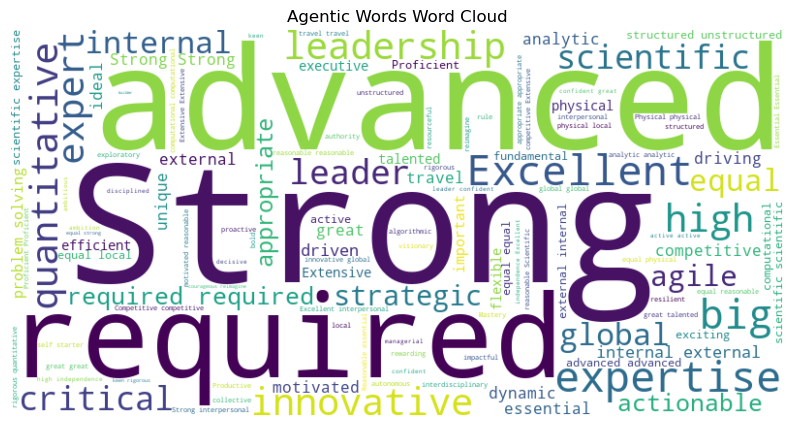

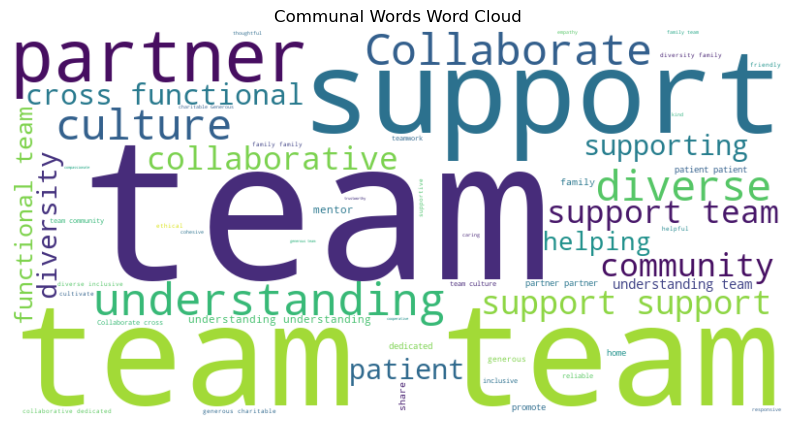

In [83]:
# Generate word clouds for agentic and communal words
agentic_text = ' '.join(df['Agentic_Words'].dropna())
communal_text = ' '.join(df['Communal_Words'].dropna())

# Plot word cloud for agentic words
agentic_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(agentic_text)
plt.figure(figsize=(10, 6))
plt.imshow(agentic_wordcloud, interpolation='bilinear')
plt.title('Agentic Words Word Cloud')
plt.axis('off')
plt.show()

# Plot word cloud for communal words
communal_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(communal_text)
plt.figure(figsize=(10, 6))
plt.imshow(communal_wordcloud, interpolation='bilinear')
plt.title('Communal Words Word Cloud')
plt.axis('off')
plt.show()

<Figure size 1000x600 with 0 Axes>

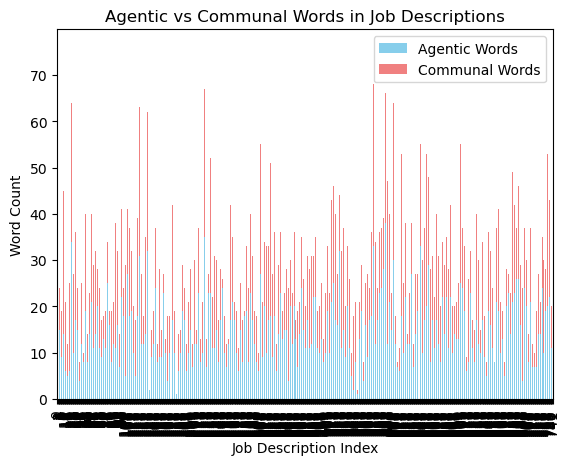

In [84]:
# Plot the counts
plt.figure(figsize=(10, 6))
df[['Agentic_Count', 'Communal_Count']].plot(kind='bar', stacked=True, color=['skyblue', 'lightcoral'])
plt.title('Agentic vs Communal Words in Job Descriptions')
plt.xlabel('Job Description Index')
plt.ylabel('Word Count')
plt.legend(['Agentic Words', 'Communal Words'])
plt.show()


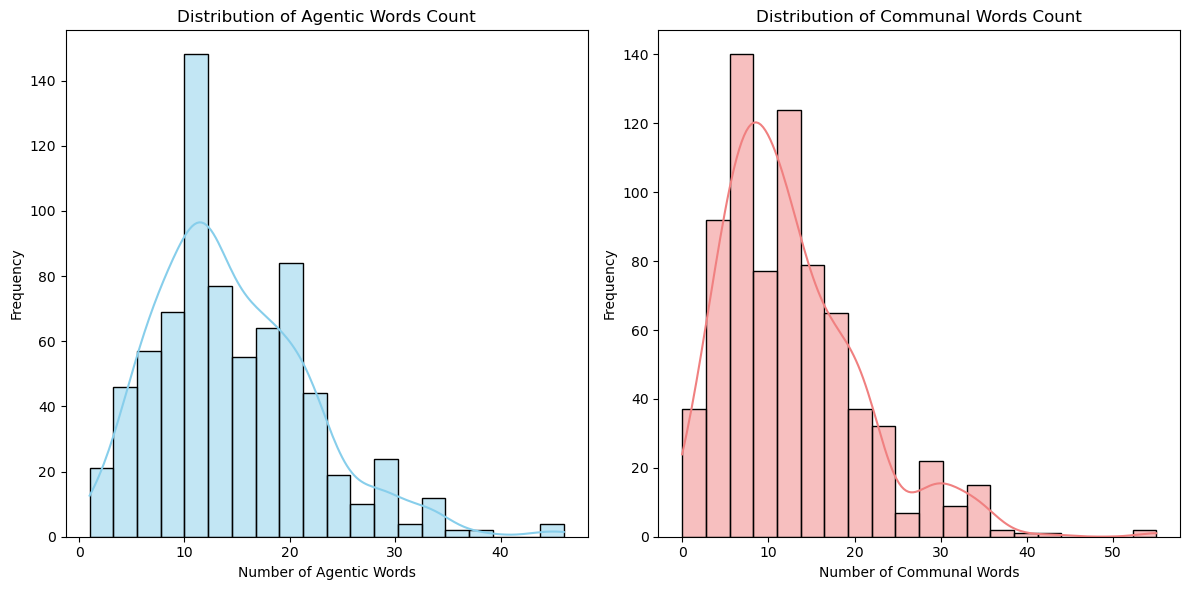

In [85]:
# Plot histogram for agentic words count
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Agentic_Count'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Agentic Words Count')
plt.xlabel('Number of Agentic Words')
plt.ylabel('Frequency')

# Plot histogram for communal words count
plt.subplot(1, 2, 2)
sns.histplot(df['Communal_Count'], bins=20, kde=True, color='lightcoral')
plt.title('Distribution of Communal Words Count')
plt.xlabel('Number of Communal Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

##  Creating a New Data Set with Additional Features

### Handling Missing Values in New Data Set

    The following code was executed, revealing rows that did not have any detected communal or agentic words. The descriptions were reviewed and the agentic_words and communal_words lists were updated to add words that should have been included. The remaining missing values were handled by filling missing values for Agentic_Words and Communal_Words with an empty string.
---
#### Check column names and data types

    print(df.info())
    print(df.head(3))
___
#### Check for missing values

    print("\nMissing Values:")
    print(df.isnull().sum())
---
#### Filter rows with missing values in "Agentic_Words" and "Communal_Words"

    missing_values_df = df[df['Agentic_Words'].isna() | df['Communal_Words'].isna()]
---
#### Save the filtered DataFrame to a new CSV file for analysis

    missing_values_df.to_csv('missing_values.csv', index=False)
    
    print("Filtered rows with missing values have been saved to 'missing_values.csv'")
---
#### Handling Missing Values

    df['Agentic_Words'] = df['Agentic_Words'].fillna('')
    df['Communal_Words'] = df['Communal_Words'].fillna('')
---
#### Fill missing values for Agentic_Words and Communal_Words with an empty string

    df['Agentic_Words'] = df['Agentic_Words'].fillna('')
    df['Communal_Words'] = df['Communal_Words'].fillna('')


## Feature Engineering for Gender Bias Target Assessment

In [86]:
# Calculate the ratio of Agentic to Communal words
# Handle cases where Communal_Count is 0 by replacing the resulting infinity with NaN
df['Gendered_Ratio'] = df['Agentic_Count'] / df['Communal_Count'].replace(0, np.nan)

# Handle NaN values by filling with 0 (or another value if desired)
df['Gendered_Ratio'] = df['Gendered_Ratio'].fillna(0)

# Display the DataFrame with the new feature
print(df[['Agentic_Count', 'Communal_Count', 'Gendered_Ratio']].head())


   Agentic_Count  Communal_Count  Gendered_Ratio
0             16               8        2.000000
1             23               8        2.875000
2             12               5        2.400000
3             15               9        1.666667
4              9              10        0.900000


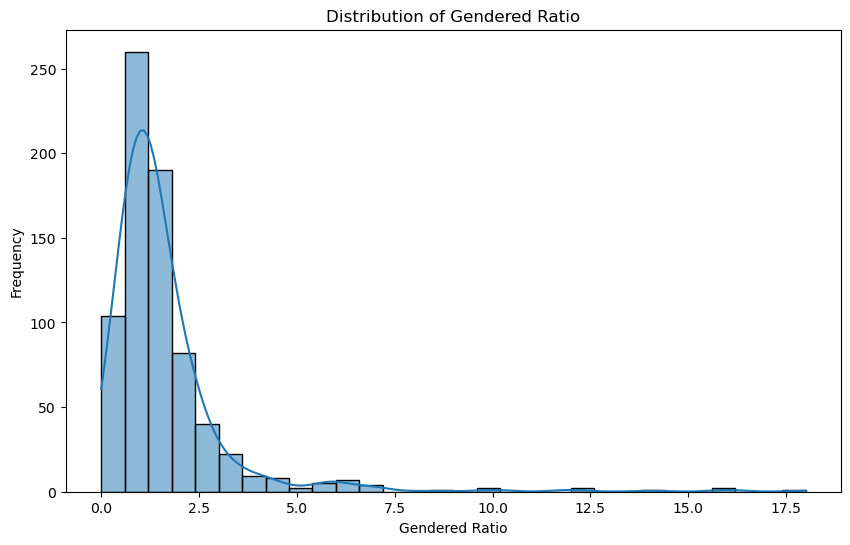

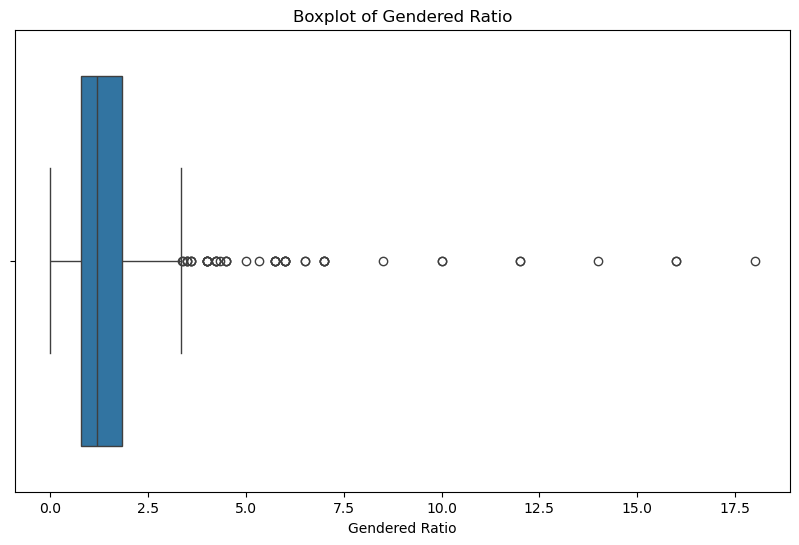

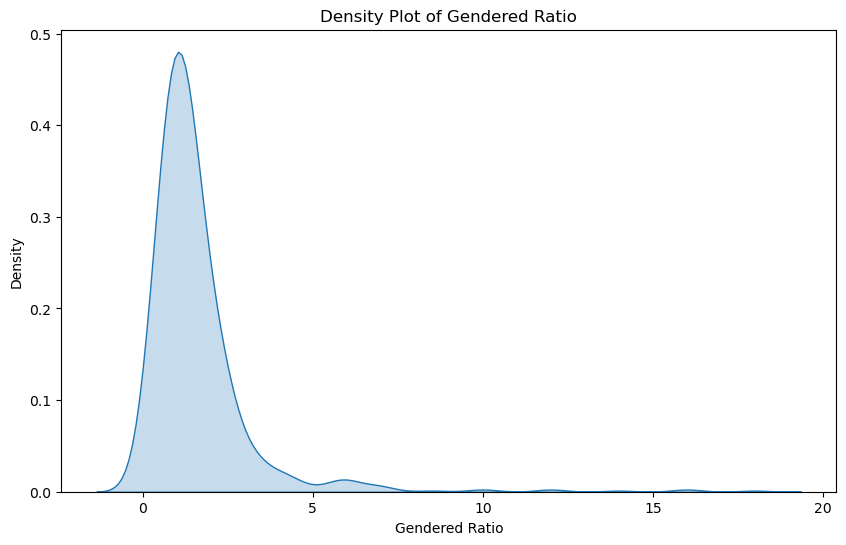

In [87]:
# Plot histogram of Gendered_Ratio
plt.figure(figsize=(10, 6))
sns.histplot(df['Gendered_Ratio'], bins=30, kde=True)
plt.title('Distribution of Gendered Ratio')
plt.xlabel('Gendered Ratio')
plt.ylabel('Frequency')
plt.show()

# Plot boxplot of Gendered_Ratio
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Gendered_Ratio'])
plt.title('Boxplot of Gendered Ratio')
plt.xlabel('Gendered Ratio')
plt.show()

# Plot density plot of Gendered_Ratio with updated parameter
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Gendered_Ratio'], fill=True)  # Use fill=True instead of shade=True
plt.title('Density Plot of Gendered Ratio')
plt.xlabel('Gendered Ratio')
plt.ylabel('Density')
plt.show()

### Handling Outliers

In [88]:
# Calculate the IQR for Gendered_Ratio
Q1 = df['Gendered_Ratio'].quantile(0.25)
Q3 = df['Gendered_Ratio'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_cleaned = df[(df['Gendered_Ratio'] >= lower_bound) & (df['Gendered_Ratio'] <= upper_bound)]

print(df_cleaned[['Gendered_Ratio']].describe())


       Gendered_Ratio
count      693.000000
mean         1.264937
std          0.680338
min          0.000000
25%          0.769231
50%          1.153846
75%          1.647059
max          3.333333


## Create New data set file: 'gendered_data.csv'

In [89]:
# Save the modified DataFrame to a new CSV file
df.to_csv('gendered_data.csv', index=False)